<a href="https://colab.research.google.com/github/freethechicken/pbh_simulations/blob/main/RFSIMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Import packages

#import cupy as cp
#from cupyx.scipy.special import erf

import numpy as np
#import pyfftw
import matplotlib.pyplot as plt
import imageio
import gc
import os
import psutil

from scipy.special import erf
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

import h5py

In [ ]:
# @title 1.11 GPU Random field simulations

class GPU_RFSIM:

    def __init__(self, mean, std_dev, pixel, z_pixel, amplitude, k_power, lamb, n_sigma):
        self.mean = mean
        self.std_dev = std_dev
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.amplitude = amplitude
        self.k_power = k_power
        self.lamb = lamb
        self.n_sigma = n_sigma

    def get_process_memory(self):
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / (1024 ** 2)  # Return memory usage in MB

    def grf_32f(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel)).astype(cp.float32)
        #print(f"white_noise allocates: {white_noise.nbytes / (1024**2):.2f} MB of memory.")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        fft_white_noise = cp.fft.fftn(white_noise).astype(cp.complex64)
        del white_noise
        #print(f"fft_white_noise allocates: {fft_white_noise.nbytes / (1024**2):.2f} MB of memory.")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx.astype(cp.float32), ky.astype(cp.float32), kz.astype(cp.float32), sparse = True)
        del kx, ky, kz
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2).astype(cp.float32)
        k_norm[0][0][0] = cp.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid
        #print(f"k_norm allocates: {k_norm.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power))).astype(cp.complex64)  # P(k)=amplitude/k^{power},
        del k_norm
        #print(f"power_spectrum allocates: {power_spectrum.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise
        #print(f"fourier_amplitudes_sqrt allocates: {fourier_amplitudes_sqrt.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()
        #print(f"gaussian_random_field allocates: {gaussian_random_field.nbytes / (1024**2):.2f} MB of memory")
        print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        return gaussian_random_field


    def grf_64f(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel))
        #print(f"white_noise allocates: {white_noise.nbytes / (1024**2):.2f} MB of memory.")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        fft_white_noise = cp.fft.fftn(white_noise)
        del white_noise
        #print(f"fft_white_noise allocates: {fft_white_noise.nbytes / (1024**2):.2f} MB of memory.")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz, sparse = True)
        del kx, ky, kz
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2)
        k_norm[0][0][0] = cp.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid
        #print(f"k_norm allocates: {k_norm.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power)))  # P(k)=amplitude/k^{power},
        del k_norm
        #print(f"power_spectrum allocates: {power_spectrum.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise
        #print(f"fourier_amplitudes_sqrt allocates: {fourier_amplitudes_sqrt.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()
        #print(f"gaussian_random_field allocates: {gaussian_random_field.nbytes / (1024**2):.2f} MB of memory")
        print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        return gaussian_random_field


    def gaussian_to_exp(self, grf, lam):
        grf_mean = cp.mean(grf)
        grf_std_dev = cp.std(grf)
        xu = 0.5 * (1 + erf((grf - grf_mean) / (cp.sqrt(2) * grf_std_dev)))

        gc.collect()

        exprf = -1/self.lamb  * cp.log(1 - xu)

        return exprf
#        return gaussian_random_field

    def statistic_overview(self, exprf):

        all_points = cp.asnumpy(exprf.flatten())
        exprf_std = np.std(all_points)
        exprf_mean = np.mean(all_points)
        cutoff = exprf_mean + self.n_sigma*exprf_std

        plt.style.use('seaborn-darkgrid')
        #print(f'Standard deviation = {exprf_std_3d:.2f}')
        #print(f'Mean = {exprf_mean_3d:.2f}')
        #print(f'Cutoff = {cutoff_3d:.2f}, i.e. {n_sigma} Sigmas from the mean at {exprf_mean_3d:.2f}')

        # Create a figure object
        fig, ax = plt.subplots()

        ax.hist(all_points, bins=100)
        ax.set_yscale('log')
        ax.set_xlabel('Field amplitude', fontsize=12)
        ax.set_ylabel('Number of data points (Log)', fontsize=12)
        ax.axvline(x=cutoff, color='r', linestyle='-', label='Cutoff amplitude')

        # Add text to the plot
        textstr = f'Std. Dev. = {exprf_std:.2f}\nMean = {exprf_mean:.2f}\nCutoff = {cutoff:.2f} ({n_sigma} Std. Dev. from mean)'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ax.set_title('Random Field Statistics', fontsize=14)
        ax.legend(loc='upper right')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Save the plot with text
        #plt.savefig(f'Statistic_info_Threshold_at_{cutoff}.pdf')
        plt.show()

        return fig, cutoff, exprf_std, exprf_mean

In [ ]:
# @title 1.12 GPU Cluster analysis

class GPU_CLUS_ANAL:

    def __init__(self, exprf, pixel, z_pixel):
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.exprf = exprf

    def masking(self, cutoff):
        # 5. Save mask and positions where amplitude exceed threshold
        mask = cp.abs(self.exprf) > cutoff
        masked_positions = cp.argwhere(mask)
        # cp.save(f'mask_at_{cutoff:.1f}.npy', mask)
        # cp.save(f'mask_positions_at_{cutoff:.1f}.npy', masked_positions)

        return masked_positions

    def dbscan(self, eps, min_sam, masked_positions):
        dbscans = DBSCAN(eps=eps, min_samples=min_sam)
        cluster_labels = dbscans.fit_predict(masked_positions)

        return cluster_labels

    def submanifolds(self, masked_positions, lx, ly, lz):
        sub_manifolds_list={}
        total_mass={}

        for ii in range(masked_positions.shape[0]):
            x, y, z = masked_positions[ii]
            x_min, x_max = max(x- lx,0), min(x+ lx +1, self.pixel)
            y_min, y_max = max(y- ly,0), min(y+ ly +1, self.pixel)
            z_min, z_max = max(z- lz,0), min(z+ lz +1, self.z_pixel)

            sub_exprf = self.exprf[x_min:x_max, y_min:y_max, z_min:z_max]
            sub_manifolds_list[ii] = sub_exprf
            total_mass[ii] = cp.sum(sub_exprf)

        cp.save(f'sub_manifolds_list.npy', sub_manifolds_list )
        cp.save(f'total_amplitude.npy', total_mass)

        return sub_manifolds_list, total_mass

        # @title 1.4 DBSCAN

    def cluster_distances(self, masked_positions, labels):
        cluster_centers = {}

        # Find unique cluster labels (excluding noise -1)
        unique_labels = set(labels) - {-1}

        # Calculate cluster centers
        for ii in set(unique_labels):
            cluster_indices = cp.where(labels == ii)[0]
            cluster_positions = masked_positions[cluster_indices]
            cluster_center = cp.mean(cluster_positions, axis=0)
            cluster_centers[ii] = cluster_center

        # Calculate distances between cluster centers
        distances = []
        for aa in cluster_centers:
            for bb in cluster_centers:
                if aa != bb & bb > aa:
                    distance = euclidean_distances([cluster_centers[aa]], [cluster_centers[bb]])
                    distances.append((aa,bb, distance))

        return distances


    def cluster_distribution_3d(self, positions, labels):

        all_cluster_position = {}
        cluster_field_values={}
        for ii in set(labels):
            cluster_indices = cp.where(labels == ii)[0]
            all_cluster_position[ii+1] = positions[cluster_indices]
            cluster_field_values[ii+1] = self.exprf[all_cluster_position[ii+1][:,0],
                                            all_cluster_position[ii+1][:,1],
                                            all_cluster_position[ii+1][:,2]]

        for ii in set(labels):
            plt.hist(cluster_field_values[ii+1].flatten(), bins = 100, label=f'Cluster {ii}', alpha=0.3);
            #plt.yscale('log')
            plt.xlabel('Field amplitude')
            plt.ylabel('Number of samples')
            plt.title(f'Cluster Distribution')
            plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
            plt.grid(True)

        return cluster_field_values


    def cluster_plot_3D(self, positions, labels):

        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')

        for ii in set(labels):
            cluster_index = cp.where(labels == ii)[0]
            cluster_positions = positions[cluster_index]

            if ii == -1:
                ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                        s=3, color='black', label='Anomaly')
            else:
                ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                        s=3, label=f'Cluster {ii}')

        ax.set_xlabel('X', fontsize=10)
        ax.set_ylabel('Y', fontsize=10)
        ax.set_zlabel('Z', fontsize=10)
        ax.set_title(f'Clustered 3D field config', fontsize=14)
        plt.legend()
        plt.show()

In [ ]:
# @title 1.21 CPU Random field simulations

class RFSIM:

    def __init__(self, mean, std_dev, pixel, z_pixel, amplitude, k_power, lamb, n_sigma):
        self.mean = mean
        self.std_dev = std_dev
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.amplitude = amplitude
        self.k_power = k_power
        self.lamb = lamb
        self.n_sigma = n_sigma

    def get_process_memory(self):
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / (1024 ** 2)  # Return memory usage in MB

    def grf_32f(self):

        # Generates and Fast Fourier transform of the white noise
        white_noise = np.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel)).astype(np.float32)

        # Create FFTW object for forward and backward FFT
        fft_obj = pyfftw.builders.fftn(white_noise, axes=(0, 1, 2))
        ifft_obj = pyfftw.builders.ifftn(fft_obj.output_array, axes=(0, 1, 2))

        # Perform the FFT
        fft_white_noise = fft_obj().astype(np.complex64)
        #fft_white_noise = np.fft.fftn(white_noise).astype(np.complex64)
        del white_noise
        gc.collect()

        # Generating FFT momentum
        kx = np.fft.fftfreq(self.pixel)*self.pixel
        ky = np.fft.fftfreq(self.pixel)*self.pixel
        kz = np.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = np.meshgrid(kx.astype(np.float32), ky.astype(np.float32), kz.astype(np.float32), sparse = True)
        del kx, ky, kz
        gc.collect()
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = np.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2).astype(np.float32)
        k_norm[0][0][0] = np.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid
        gc.collect()

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*np.pi/self.pixel)*k_norm)**(-1*self.k_power))).astype(np.complex64)  # P(k)=amplitude/k^{power},
        del k_norm
        gc.collect()

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  np.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise
        gc.collect()
        #print(f"fourier_amplitudes_sqrt allocates: {fourier_amplitudes_sqrt.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = ifft_obj(fourier_amplitudes_sqrt).real
        #gaussian_random_field = np.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()
        #print(f"gaussian_random_field allocates: {gaussian_random_field.nbytes / (1024**2):.2f} MB of memory")
        print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        return gaussian_random_field


    def grf_64f(self):

        # Generates and Fast Fourier transform of the white noise
        white_noise = np.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel))

        # Create FFTW object for forward and backward FFT
        fft_obj = pyfftw.builders.fftn(white_noise, axes=(0, 1, 2))
        ifft_obj = pyfftw.builders.ifftn(fft_obj.output_array, axes=(0, 1, 2))

        # Perform the FFT
        fft_white_noise = fft_obj()
        #fft_white_noise = np.fft.fftn(white_noise).astype(np.complex64)
        del white_noise
        gc.collect()

        # Generating FFT momentum
        kx = np.fft.fftfreq(self.pixel)*self.pixel
        ky = np.fft.fftfreq(self.pixel)*self.pixel
        kz = np.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = np.meshgrid(kx , ky , kz , sparse = True)
        del kx, ky, kz
        gc.collect()
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = np.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2)
        k_norm[0][0][0] = np.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid
        gc.collect()

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*np.pi/self.pixel)*k_norm)**(-1*self.k_power)))  # P(k)=amplitude/k^{power},
        del k_norm
        gc.collect()

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  np.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise
        gc.collect()
        #print(f"fourier_amplitudes_sqrt allocates: {fourier_amplitudes_sqrt.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = ifft_obj(fourier_amplitudes_sqrt).real
        #gaussian_random_field = np.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()
        #print(f"gaussian_random_field allocates: {gaussian_random_field.nbytes / (1024**2):.2f} MB of memory")
        print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        return gaussian_random_field
    def gaussian_to_exp(self, grf, lam):
        grf_mean = np.mean(grf)
        grf_std_dev = np.std(grf)
        xu = 0.5 * (1 + erf((grf - grf_mean) / (np.sqrt(2) * grf_std_dev)))

        gc.collect()

        exprf = -1/self.lamb  * np.log(1 - xu)

        return exprf
#        return gaussian_random_field

    def statistic_overview(self, exprf):

        all_points = exprf.flatten()
        exprf_std = np.std(all_points)
        exprf_mean = np.mean(all_points)
        cutoff = exprf_mean + self.n_sigma*exprf_std

        plt.style.use('seaborn-darkgrid')
        #print(f'Standard deviation = {exprf_std_3d:.2f}')
        #print(f'Mean = {exprf_mean_3d:.2f}')
        #print(f'Cutoff = {cutoff_3d:.2f}, i.e. {n_sigma} Sigmas from the mean at {exprf_mean_3d:.2f}')

        # Create a figure object
        fig, ax = plt.subplots()

        ax.hist(all_points, bins=100)
        ax.set_yscale('log')
        ax.set_xlabel('Field amplitude', fontsize=12)
        ax.set_ylabel('Number of data points (Log)', fontsize=12)
        ax.axvline(x=cutoff, color='r', linestyle='-', label='Cutoff amplitude')

        # Add text to the plot
        textstr = f'Std. Dev. = {exprf_std:.2f}\nMean = {exprf_mean:.2f}\nCutoff = {cutoff:.2f} ({n_sigma} Std. Dev. from mean)'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ax.set_title('Random Field Statistics', fontsize=14)
        ax.legend(loc='upper right')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Save the plot with text
        #plt.savefig(f'Statistic_info_Threshold_at_{cutoff}.pdf')
        plt.show()

        return fig, cutoff, exprf_std, exprf_mean

In [ ]:
# @title 1.22 Cluster analysis

class CLUS_ANAL:

    def __init__(self, exprf, pixel, z_pixel):
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.exprf = exprf

    def masking(self, cutoff):
        # 5. Save mask and positions where amplitude exceed threshold
        mask = np.abs(self.exprf) > cutoff
        masked_positions = np.argwhere(mask)
        # np.save(f'mask_at_{cutoff:.1f}.npy', mask)
        # np.save(f'mask_positions_at_{cutoff:.1f}.npy', masked_positions)

        return masked_positions

    def dbscan(self, eps, min_sam, masked_positions):
        dbscans = DBSCAN(eps=eps, min_samples=min_sam)
        cluster_labels = dbscans.fit_predict(masked_positions)

        return cluster_labels

    def submanifolds(self, masked_positions, lx, ly, lz):
        sub_manifolds_list={}
        total_mass={}

        for ii in range(masked_positions.shape[0]):
            x, y, z = masked_positions[ii]
            x_min, x_max = max(x-lx,0), min(x+lx +1, self.pixel)
            y_min, y_max = max(y-ly,0), min(y+ly +1, self.pixel)
            z_min, z_max = max(z-lz,0), min(z+lz +1, self.z_pixel)

            sub_exprf = self.exprf[x_min:x_max, y_min:y_max, z_min:z_max]
            sub_manifolds_list[ii] = sub_exprf
            total_mass[ii] = np.sum(sub_exprf)

        np.save(f'sub_manifolds_list.npy', sub_manifolds_list )
        np.save(f'total_amplitude.npy', total_mass)

        return sub_manifolds_list, total_mass

        # @title 1.4 DBSCAN

    def cluster_distances(self, masked_positions, labels):
        cluster_centers = {}

        # Find unique cluster labels (excluding noise -1)
        unique_labels = set(labels) - {-1}

        # Calculate cluster centers
        for ii in set(unique_labels):
            cluster_indices = np.where(labels == ii)[0]
            cluster_positions = masked_positions[cluster_indices]
            cluster_center = np.mean(cluster_positions, axis=0)
            cluster_centers[ii] = cluster_center

        # Calculate distances between cluster centers
        distances = []
        for aa in cluster_centers:
            for bb in cluster_centers:
                if aa != bb & bb > aa:
                    distance = euclidean_distances([cluster_centers[aa]], [cluster_centers[bb]])
                    distances.append((aa,bb, distance))

        return distances


    def cluster_distribution_3d(self, positions, labels):

        all_cluster_position = {}
        cluster_field_values={}
        for ii in set(labels):
            cluster_indices = np.where(labels == ii)[0]
            all_cluster_position[ii+1] = positions[cluster_indices]
            cluster_field_values[ii+1] = self.exprf[all_cluster_position[ii+1][:, 0],
                                                    all_cluster_position[ii+1][:, 1],
                                                    all_cluster_position[ii+1][:, 2]]

        fig, ax = plt.subplots()
        for ii in set(labels):
            ax.hist(cluster_field_values[ii+1].flatten(), bins=100, label=f'Cluster {ii}', alpha=0.3)

        ax.set_xlabel('Field amplitude')
        ax.set_ylabel('Number of samples')
        ax.set_title('Cluster Distribution')
        ax.legend(loc='upper right')
        ax.grid(True)

        return fig, cluster_field_values


    def cluster_plot_3D(self, positions, labels):

        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')

        for ii in set(labels):
            cluster_index = np.where(labels == ii)[0]
            cluster_positions = positions[cluster_index]

            if ii == -1:
                ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                        s=3, color='black', label='Anomaly')
            else:
                ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                        s=3, label=f'Cluster {ii}')

        ax.set_xlabel('X', fontsize=10)
        ax.set_ylabel('Y', fontsize=10)
        ax.set_zlabel('Z', fontsize=10)
        ax.set_title(f'Clustered 3D field config', fontsize=14)
        plt.legend()
        plt.show()

        return fig

In [ ]:
# @title  1.5 Visualization

def plot_3d_scatter_field(exprf, cutoff):
    # Normalize the field values
    normalized_fig = exprf / np.abs(exprf).max()

    # Create 3D meshgrid
    x, y, z = np.meshgrid(range(exprf.shape[0]),
                          range(exprf.shape[1]),
                          range(exprf.shape[2]))

    figu = plt.figure(figsize=(6, 6))
    ax = figu.add_subplot(111, projection='3d')

    # Plot scatters above the threshold values
    scatterplts = ax.scatter(x[np.abs(exprf) > cutoff],
                            y[np.abs(exprf)  > cutoff],
                            z[np.abs(exprf)  > cutoff],
                            c=normalized_fig[np.abs(exprf) > cutoff],
                            s=5,
                            cmap='viridis')
    #                        alpha=alphas[np.abs(normalized_fig) > threshold])

    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)
    ax.set_title(f'3D Field Config', fontsize=14)
    figu.colorbar(scatterplts, ax=ax, label='Field Amplitude', shrink=0.5)
    figu.patch.set_facecolor('white')

    plt.show()



In [ ]:
# Paramters
pixel = 2**9
z_pixel = pixel
n_sigma = 25


eps = 25
min_sam = 5
cluster_cutoff = 13


default_l = 6 # This is the length from the center to the edge
lx = default_l
ly = default_l
lz = default_l

Nloops = 3000


# DATA GENERATION

In [ ]:
# @title Mount gdrive and directory
from google.colab import drive
drive.mount('/content/gdrive/')
folder_path = '/content/gdrive/MyDrive/2023 RFSimulations/simulated_field'
os.chdir(folder_path)
print("Current Working Directory:", os.getcwd())

Mounted at /content/gdrive/
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_field


In [ ]:
test_file_name = 'test_file.txt'
test_content = 'This is a test file to confirm output on the working directory.'

with open(test_file_name, 'w') as file:
    file.write(test_content)

print(f"Test file has been created in the directory '{folder_path}'.")

Test file has been created in the directory '/content/gdrive/MyDrive/2023 RFSimulations/simulated_field'.


In [ ]:

for ii in tqdm(range(Nloops), desc="Processing"):
    # Initialize an instance of RFSIM
    # rfsim = RFSIM(mean=0, std_dev=1, pixel=pixel, z_pixel=z_pixel, amplitude=1.0, k_power=3, lamb=1.0, n_sigma=n_sigma+1)
    rfsim = GPU_RFSIM(mean=0, std_dev=1, pixel=pixel, z_pixel=z_pixel, amplitude=1.0, k_power=3, lamb=1.0, n_sigma=n_sigma+1)
    # Generate a Gaussian random field
    grf = rfsim.grf_64f()  # grf can be _32f or _64f
    # Apply Gaussian to exponential transformation
    exprf = rfsim.gaussian_to_exp(grf, lam=1.0)
    del grf
    #gc.collect()


    # Check if masked_positions is empty
    # clus_anal = CLUS_ANAL(exprf=exprf,  pixel=pixel, z_pixel=z_pixel)
    clus_anal = GPU_CLUS_ANAL(exprf=exprf,  pixel=pixel, z_pixel=z_pixel)
    masked_positions = clus_anal.masking(cutoff = n_sigma+1)

    if len(masked_positions) > 0:
        new_folder = f"simulated_field_{ii}"
        new_path = f"simulated_field_{ii}/"
        os.makedirs(new_folder, exist_ok=True)

        stat_fig, cutoff, exprf_std, exprf_mean = rfsim.statistic_overview(exprf)
        stat_fig.savefig(  f'Statistic_{ii}_Threshold_at_{cutoff:.1f}.pdf')
        cp.save(  f'exprf_{ii}.npy',exprf)
        print(f'Found rare event at simulation {ii}')

    del exprf
    #gc.collect()

# DATA ANALYSIS

In [ ]:
# Initialize an instance of RFSIM
folder_path = '/content/gdrive/MyDrive/2023 RFSimulations/simulated_results'
os.chdir(folder_path)
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results


In [ ]:
instance_id = 797
length_list = {2,5,25}

In [ ]:
exprf = np.load(f'exprf_{instance_id}.npy')

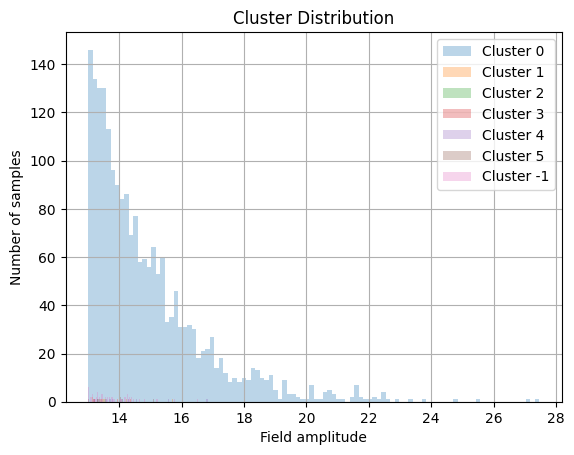

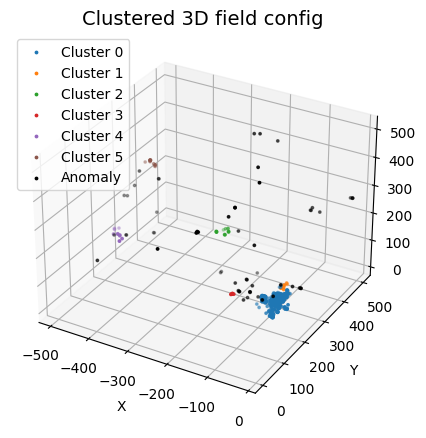

In [ ]:
# Initialize
clus_anal = CLUS_ANAL(exprf=exprf , pixel=pixel, z_pixel=z_pixel)

# Locate rare event by mask
nsigmas_masked_positions = clus_anal.masking(cutoff = n_sigma+1)


# Masking for amplitudes beyond 5 Sigmas:
masked_positions = clus_anal.masking(cutoff = cluster_cutoff)

# DBSCAN
cluster_labels = clus_anal.dbscan(eps=eps, min_sam=min_sam, masked_positions=masked_positions)

# Clustering Distances
#distances = clus_anal.cluster_distances(masked_positions, cluster_labels)

# Cluster amplitude distributions
cluster_distribution_figure, cluster_field_values = clus_anal.cluster_distribution_3d(masked_positions, cluster_labels)
cluster_distribution_figure.savefig(f'Cluster_amplitude_distribution_{instance_id}.pdf')

# 3D scattering of cluster
clustering_figures = clus_anal.cluster_plot_3D(masked_positions, cluster_labels)
clustering_figures.savefig(f'Cluster_3D_distribution_{instance_id}.pdf')

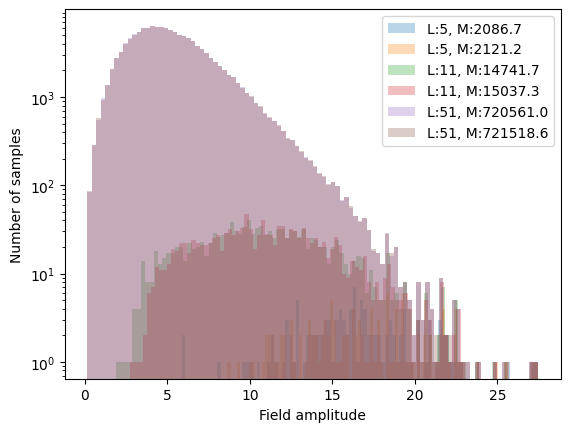

In [ ]:
# @title Find all points within a shape of the rectange of size lx*ly*lz

fig, ax = plt.subplots()
total_mass_list = {}
density_profile = {}

for l in range(eps+5):
    sub_manifolds, total_mass = clus_anal.submanifolds(nsigmas_masked_positions, lx=l , ly=l , lz=l)
    density_profile[l] = total_mass[0]  / ((2*l+1)**3)
    #total_mass_list.append(total_mass)
    if l in length_list:
        for ii in range(nsigmas_masked_positions.shape[0]):
            ax.hist(sub_manifolds[ii].flatten(),bins=100, label=f'L:{2*l+1}, M:{total_mass[ii]:.1f}', alpha=0.3);
            ax.set_xlabel('Field amplitude')
            ax.set_ylabel('Number of samples')
            ax.set_yscale('log')
plt.legend()
plt.show()

fig.savefig(f'Cluster_distributions_by_volume_{instance_id}.pdf')

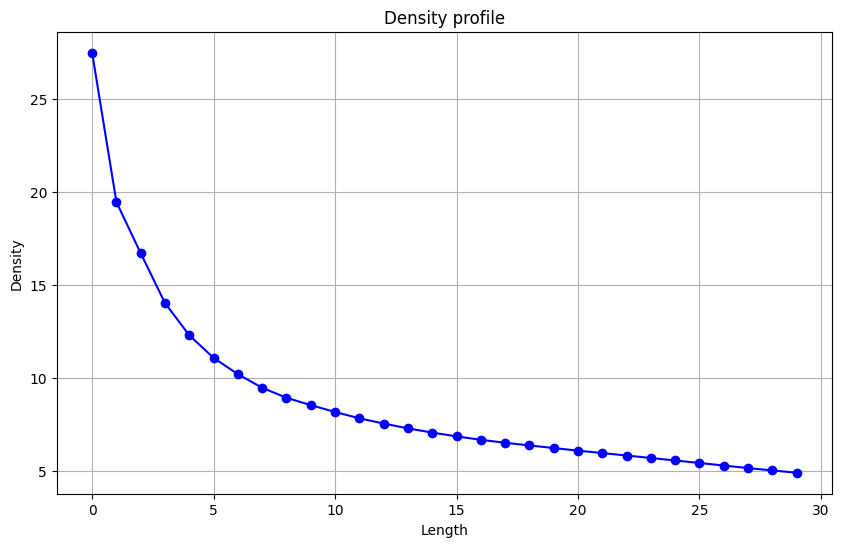

In [ ]:
# @title Density profiling

indices = list(density_profile.keys())
values = list(density_profile.values())

fig, ax = plt.subplots(figsize=[10,6])
ax.plot(indices, values, marker='o', color='b', linestyle='-')
ax.set_xlabel('Length')
ax.set_ylabel('Density')
ax.set_title('Density profile')
ax.grid(True)


fig.savefig(f'Cluster_density_profile_{instance_id}.pdf')

In [ ]:
density_profile

{0: 27.462546871957265,
 1: 65.61640787348146,
 2: 77.28581238962231,
 3: 75.1285124800802,
 4: 71.67005058280728,
 5: 68.24845843102815,
 6: 65.3293905344171,
 7: 62.423216254732566,
 8: 60.21151591769273,
 9: 58.56829012399832,
 10: 56.85972878940462,
 11: 55.14439224063722,
 12: 53.70222482611564,
 13: 52.300206950399286,
 14: 51.05134379409663,
 15: 49.906980300473975,
 16: 48.84285792615382,
 17: 47.91986311780731,
 18: 47.08045506893097,
 19: 46.225664769701105,
 20: 45.36822841936528,
 21: 44.54199096711448,
 22: 43.69055358821438,
 23: 42.81206535523911,
 24: 41.91856765834931,
 25: 40.99687053973173,
 26: 40.05048032507252,
 27: 39.11252838795327,
 28: 38.20845122214528,
 29: 37.34764007289125}

In [ ]:
4/2

2.0